In [1]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
 

In [4]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y
 
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy
 
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 10, 32
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(Dropout(0.5))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy
 
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
# run an experiment
def run_experiment(repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)
 
# run the experiment
run_experiment()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>#1: 92.840
>#2: 92.229
>#3: 91.279
>#4: 90.193
>#5: 91.483
>#6: 92.331
>#7: 90.702
>#8: 89.481
>#9: 90.159
>#10: 90.804
[92.840176820755, 92.22938418388367, 91.27926826477051, 90.19341468811035, 91.48286581039429, 92.33118295669556, 90.7024085521698, 89.4808292388916, 90.15948176383972, 90.80420732498169]
Accuracy: 91.150% (+/-1.027)


(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
(470528, 9)


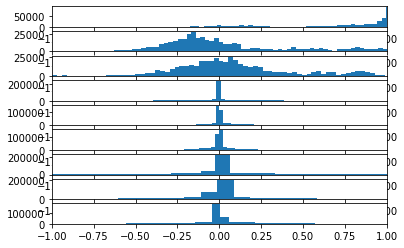

In [5]:
# plot a histogram of each variable in the dataset
def plot_variable_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()
 
# load data
trainX, trainy, testX, testy = load_dataset()
# plot histograms
plot_variable_distributions(trainX)

In [6]:
# standardize data
def scale_data(trainX, testX, standardize):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	# flatten train and test
	flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
	flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))
	# standardize
	if standardize:
		s = StandardScaler()
		# fit on training data
		s.fit(longX)
		# apply to training and test data
		longX = s.transform(longX)
		flatTrainX = s.transform(flatTrainX)
		flatTestX = s.transform(flatTestX)
	# reshape
	flatTrainX = flatTrainX.reshape((trainX.shape))
	flatTestX = flatTestX.reshape((testX.shape))
	return flatTrainX, flatTestX

In [7]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, param):
	verbose, epochs, batch_size = 0, 10, 32
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	# scale data
	trainX, testX = scale_data(trainX, testX, param)
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(Dropout(0.5))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy

In [8]:
# run an experiment
def run_experiment(params, repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# test each parameter
	all_scores = list()
	for p in params:
		# repeat experiment
		scores = list()
		for r in range(repeats):
			score = evaluate_model(trainX, trainy, testX, testy, p)
			score = score * 100.0
			print('>p=%d #%d: %.3f' % (p, r+1, score))
			scores.append(score)
		all_scores.append(scores)
	# summarize results
	summarize_results(all_scores, params)

In [9]:
def summarize_results(scores, params):
	print(scores, params)
	# summarize mean and standard deviation
	for i in range(len(scores)):
		m, s = mean(scores[i]), std(scores[i])
		print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
	# boxplot of scores
	pyplot.boxplot(scores, labels=params)
	pyplot.savefig('exp_cnn_standardize.png')

In [12]:
# cnn model with standardization
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical# run an experiment
def run_experiment(params, repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# test each parameter
	all_scores = list()
	for p in params:
		# repeat experiment
		scores = list()
		for r in range(repeats):
			score = evaluate_model(trainX, trainy, testX, testy, p)
			score = score * 100.0
			print('>p=%s #%d: %.3f' % (p, r+1, score))
			scores.append(score)
		all_scores.append(scores)
	# summarize results
	summarize_results(all_scores, params)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>p=False #1: 92.229
>p=False #2: 89.752
>p=False #3: 91.483
>p=False #4: 88.700
>p=False #5: 90.329
>p=False #6: 88.666
>p=False #7: 92.399
>p=False #8: 87.547
>p=False #9: 88.836
>p=False #10: 91.585
>p=True #1: 90.736
>p=True #2: 91.754
>p=True #3: 91.381
>p=True #4: 91.856
>p=True #5: 91.890
>p=True #6: 92.365
>p=True #7: 91.720
>p=True #8: 92.365
>p=True #9: 91.381
>p=True #10: 90.024
[[92.22938418388367, 89.75229263305664, 91.48286581039429, 88.70037198066711, 90.32914638519287, 88.66643905639648, 92.39904880523682, 87.54665851593018, 88.83610367774963, 91.58466458320618], [90.73634147644043, 91.75432920455933, 91.3810670375824, 91.85612201690674, 91.89005494117737, 92.36511588096619, 91.7203962802887, 92.36511588096619, 91.3810670375824, 90.0237500667572]] [False, True]
Param=0: 90.153% (+/-1.619)
Param=1: 91.547% (+/-0.682)


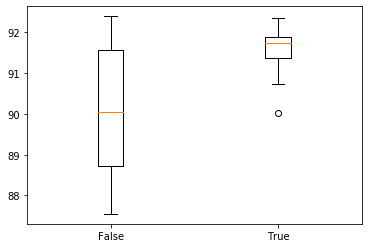

In [13]:
# run the experiment
n_params = [False, True]
run_experiment(n_params)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>p=8 #1: 90.499
>p=8 #2: 87.445
>p=8 #3: 89.650
>p=8 #4: 88.124
>p=8 #5: 91.619
>p=8 #6: 89.650
>p=8 #7: 87.072
>p=8 #8: 87.648
>p=8 #9: 89.549
>p=8 #10: 87.513
>p=16 #1: 89.718
>p=16 #2: 89.617
>p=16 #3: 89.786
>p=16 #4: 90.838
>p=16 #5: 88.633
>p=16 #6: 87.784
>p=16 #7: 89.650
>p=16 #8: 89.175
>p=16 #9: 90.974
>p=16 #10: 88.293
>p=32 #1: 90.465
>p=32 #2: 90.940
>p=32 #3: 90.770
>p=32 #4: 90.193
>p=32 #5: 89.990
>p=32 #6: 89.379
>p=32 #7: 85.239
>p=32 #8: 90.872
>p=32 #9: 88.972
>p=32 #10: 91.211
>p=64 #1: 89.175
>p=64 #2: 88.938
>p=64 #3: 89.175
>p=64 #4: 87.207
>p=64 #5: 90.533
>p=64 #6: 91.924
>p=64 #7: 91.551
>p=64 #8: 90.193
>p=64 #9: 90.465
>p=64 #10: 90.329
>p=128 #1: 91.686
>p=128 #2: 91.042
>p=128 #3: 93.180
>p=128 #4: 90.838
>p=128 #5: 91.211
>p=128 #6: 92.331
>p=128 #7: 90.092
>p=128 #8: 91.110
>p=128 #9: 87.784
>p=128 #10: 91.483
>p=256 #1: 91.381
>p=256 #2: 90.736
>p=256 #3

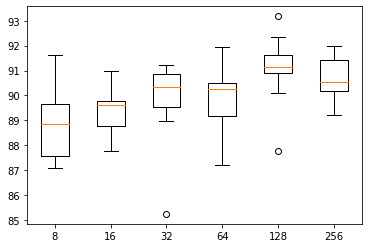

In [14]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
 
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y
 
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy
 
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, n_filters):
	verbose, epochs, batch_size = 0, 10, 32
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu'))
	model.add(Dropout(0.5))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy
 
# summarize scores
def summarize_results(scores, params):
	print(scores, params)
	# summarize mean and standard deviation
	for i in range(len(scores)):
		m, s = mean(scores[i]), std(scores[i])
		print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
	# boxplot of scores
	pyplot.boxplot(scores, labels=params)
	pyplot.savefig('exp_cnn_filters.png')
 
# run an experiment
def run_experiment(params, repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# test each parameter
	all_scores = list()
	for p in params:
		# repeat experiment
		scores = list()
		for r in range(repeats):
			score = evaluate_model(trainX, trainy, testX, testy, p)
			score = score * 100.0
			print('>p=%d #%d: %.3f' % (p, r+1, score))
			scores.append(score)
		all_scores.append(scores)
	# summarize results
	summarize_results(all_scores, params)
 
# run the experiment
n_params = [8, 16, 32, 64, 128, 256]
run_experiment(n_params)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>p=2 #1: 90.295
>p=2 #2: 89.447
>p=2 #3: 90.431
>p=2 #4: 90.567
>p=2 #5: 88.700
>p=2 #6: 89.718
>p=2 #7: 91.517
>p=2 #8: 91.517
>p=2 #9: 88.293
>p=2 #10: 87.106
>p=3 #1: 90.906
>p=3 #2: 90.431
>p=3 #3: 90.635
>p=3 #4: 90.567
>p=3 #5: 91.958
>p=3 #6: 90.906
>p=3 #7: 89.515
>p=3 #8: 92.162
>p=3 #9: 90.058
>p=3 #10: 89.820
>p=5 #1: 92.195
>p=5 #2: 90.363
>p=5 #3: 92.229
>p=5 #4: 92.162
>p=5 #5: 90.092
>p=5 #6: 90.668
>p=5 #7: 90.499
>p=5 #8: 90.363
>p=5 #9: 91.008
>p=5 #10: 93.044
>p=7 #1: 91.924
>p=7 #2: 91.076
>p=7 #3: 92.535
>p=7 #4: 91.449
>p=7 #5: 90.872
>p=7 #6: 91.076
>p=7 #7: 92.195
>p=7 #8: 89.175
>p=7 #9: 91.381
>p=7 #10: 91.144
>p=11 #1: 91.720
>p=11 #2: 90.838
>p=11 #3: 92.738
>p=11 #4: 92.772
>p=11 #5: 93.213
>p=11 #6: 92.195
>p=11 #7: 93.824
>p=11 #8: 92.060
>p=11 #9: 91.754
>p=11 #10: 90.499
[[90.29521346092224, 89.44689631462097, 90.43094515800476, 90.56667685508728, 88.7003

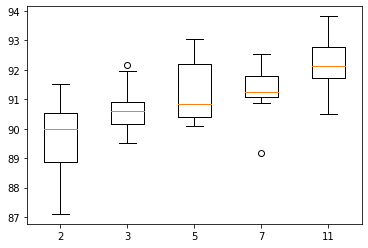

In [16]:
# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
 
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y
 
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy
 
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, n_kernel):
	verbose, epochs, batch_size = 0, 15, 32
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=n_kernel, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=n_kernel, activation='relu'))
	model.add(Dropout(0.5))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy
 
# summarize scores
def summarize_results(scores, params):
	print(scores, params)
	# summarize mean and standard deviation
	for i in range(len(scores)):
		m, s = mean(scores[i]), std(scores[i])
		print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
	# boxplot of scores
	pyplot.boxplot(scores, labels=params)
	pyplot.savefig('exp_cnn_kernel.png')
 
# run an experiment
def run_experiment(params, repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# test each parameter
	all_scores = list()
	for p in params:
		# repeat experiment
		scores = list()
		for r in range(repeats):
			score = evaluate_model(trainX, trainy, testX, testy, p)
			score = score * 100.0
			print('>p=%d #%d: %.3f' % (p, r+1, score))
			scores.append(score)
		all_scores.append(scores)
	# summarize results
	summarize_results(all_scores, params)
 
# run the experiment
n_params = [2, 3, 5, 7, 11]
run_experiment(n_params)